Epoch 1/50, Train Loss: 0.0213, Test Loss: 0.0187
Epoch 2/50, Train Loss: 0.0200, Test Loss: 0.0177
Epoch 3/50, Train Loss: 0.0196, Test Loss: 0.0168
Epoch 4/50, Train Loss: 0.0187, Test Loss: 0.0159
Epoch 5/50, Train Loss: 0.0170, Test Loss: 0.0151
Epoch 6/50, Train Loss: 0.0161, Test Loss: 0.0144
Epoch 7/50, Train Loss: 0.0157, Test Loss: 0.0137
Epoch 8/50, Train Loss: 0.0149, Test Loss: 0.0130
Epoch 9/50, Train Loss: 0.0142, Test Loss: 0.0123
Epoch 10/50, Train Loss: 0.0137, Test Loss: 0.0116
Epoch 11/50, Train Loss: 0.0129, Test Loss: 0.0110
Epoch 12/50, Train Loss: 0.0118, Test Loss: 0.0104
Epoch 13/50, Train Loss: 0.0115, Test Loss: 0.0098
Epoch 14/50, Train Loss: 0.0109, Test Loss: 0.0094
Epoch 15/50, Train Loss: 0.0098, Test Loss: 0.0089
Epoch 16/50, Train Loss: 0.0097, Test Loss: 0.0086
Epoch 17/50, Train Loss: 0.0091, Test Loss: 0.0083
Epoch 18/50, Train Loss: 0.0087, Test Loss: 0.0082
Epoch 19/50, Train Loss: 0.0089, Test Loss: 0.0081
Epoch 20/50, Train Loss: 0.0086, Test Lo

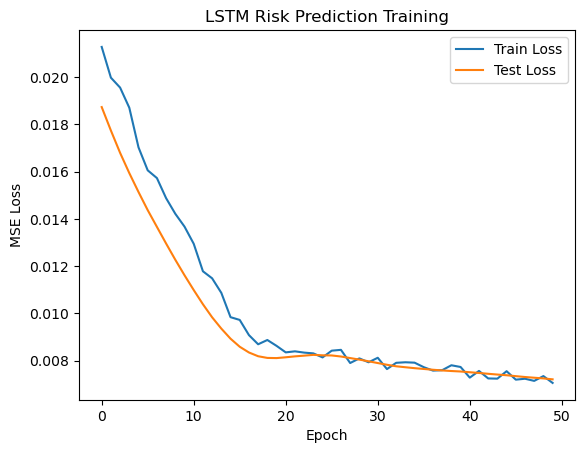

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

df = pd.read_csv("lstm data.csv")

label_encoder = LabelEncoder()
df['behaviour_encoded'] = label_encoder.fit_transform(df['Behaviour class'])

features = ['Depth', 'speed_mph', 'behaviour_encoded']
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features])
y = df[['Depth', 'speed_mph']].mean(axis=1) / 100  

sequence_length = 2
X_seq, y_seq = [], []
frame_groups = df.groupby('frame_id')

for _, group in frame_groups:
    group = group.sort_values('car_id')
    values = scaler.transform(group[features])
    target = (group[['Depth', 'speed_mph']].mean(axis=1) / 100).values  
    for i in range(len(group) - sequence_length + 1):
        X_seq.append(values[i:i + sequence_length])
        y_seq.append(target[i + sequence_length - 1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

class RiskLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RiskLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = RiskLSTM(input_size=3, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        test_loss = sum(criterion(model(X), y).item() for X, y in test_loader) / len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Risk Prediction Training")
plt.legend()
plt.show()


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

df = pd.read_csv("lstm data.csv")

label_encoder = LabelEncoder()
df['behaviour_encoded'] = label_encoder.fit_transform(df['Behaviour class'])

features = ['Depth', 'speed_mph', 'behaviour_encoded']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

sequence_length = 5
X_seq = []
sequence_indices = []

for frame_id in df['frame_id'].unique():
    frame_df = df[df['frame_id'] == frame_id].sort_values('car_id')
    values = frame_df[features].values
    if len(values) < sequence_length:
        continue 

    for i in range(len(values) - sequence_length + 1):
        X_seq.append(values[i:i + sequence_length])
        sequence_indices.append(frame_df.iloc[i + sequence_length - 1].name)

X_seq = np.array(X_seq)

class RiskLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RiskLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

proxy_risk = df[['Depth', 'speed_mph']].mean(axis=1)
y_proxy = torch.tensor(proxy_risk.values[sequence_indices] / 100, dtype=torch.float32).view(-1, 1)

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_proxy)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model = RiskLSTM(input_size=3, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(30):
    epoch_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {epoch_loss / len(loader):.4f}")

model.eval()
with torch.no_grad():
    preds = model(X_tensor).numpy().flatten()

df['risk_score'] = np.nan
for idx, score in zip(sequence_indices, preds):
    df.at[idx, 'risk_score'] = score

df['risk_score'] = df['risk_score'].fillna(method='ffill').fillna(method='bfill')

df.to_csv("lstm_risk_scored_output.csv", index=False)
print("\n Risk scores saved to: lstm_risk_scored_output.csv")


Epoch 1: Loss = 0.2268
Epoch 2: Loss = 0.2237
Epoch 3: Loss = 0.2208
Epoch 4: Loss = 0.2178
Epoch 5: Loss = 0.2149
Epoch 6: Loss = 0.2119
Epoch 7: Loss = 0.2090
Epoch 8: Loss = 0.2062
Epoch 9: Loss = 0.2037
Epoch 10: Loss = 0.2011
Epoch 11: Loss = 0.1984
Epoch 12: Loss = 0.1955
Epoch 13: Loss = 0.1925
Epoch 14: Loss = 0.1894
Epoch 15: Loss = 0.1860
Epoch 16: Loss = 0.1825
Epoch 17: Loss = 0.1788
Epoch 18: Loss = 0.1748
Epoch 19: Loss = 0.1706
Epoch 20: Loss = 0.1660
Epoch 21: Loss = 0.1612
Epoch 22: Loss = 0.1559
Epoch 23: Loss = 0.1502
Epoch 24: Loss = 0.1442
Epoch 25: Loss = 0.1376
Epoch 26: Loss = 0.1306
Epoch 27: Loss = 0.1230
Epoch 28: Loss = 0.1147
Epoch 29: Loss = 0.1061
Epoch 30: Loss = 0.0968

✅ Risk scores saved to: lstm_risk_scored_output.csv


/var/folders/lc/p25c1gl962jg729dvfxqgk100000gn/T/ipykernel_75079/81003440.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['risk_score'] = df['risk_score'].fillna(method='ffill').fillna(method='bfill')


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

df = pd.read_csv("lstm data.csv")

label_encoder = LabelEncoder()
df['behaviour_encoded'] = label_encoder.fit_transform(df['Behaviour class'])

features = ['Depth', 'speed_mph', 'behaviour_encoded']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

class RiskLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RiskLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

sequence_length = 5
sequences = []
targets = []

for i in range(sequence_length - 1, len(df)):
    seq = df.iloc[i - sequence_length + 1:i + 1][features].values
    if seq.shape[0] == sequence_length:
        sequences.append(seq)
        target = df.iloc[i][['Depth', 'speed_mph']].mean() / 100
        targets.append(target)

X = np.array(sequences)
y = np.array(targets)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

model = RiskLSTM(input_size=3, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

risk_scores = [np.nan] * len(df)

model.eval()
with torch.no_grad():
    for i in range(sequence_length - 1, len(df)):
        seq = df.iloc[i - sequence_length + 1:i + 1][features].values
        seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0) 
        pred = model(seq_tensor).item()
        risk_scores[i] = pred

df['risk_score'] = risk_scores
df['risk_score'] = df['risk_score'].fillna(method='ffill').fillna(method='bfill')

def classify_level(score):
    if score <= 0.2:
        return "Level 1: Very Low Risk"
    elif score <= 0.4:
        return "Level 2: Low Risk"
    elif score <= 0.6:
        return "Level 3: Moderate Risk"
    elif score <= 0.8:
        return "Level 4: High Risk"
    else:
        return "Level 5: Critical Risk"

df['risk_level'] = df['risk_score'].apply(classify_level)

df.to_csv("lstm_risk_per_row.csv", index=False)
print("Per-row risk scores and levels saved to lstm_risk_per_row.csv")


Epoch 1 | Loss: 0.2146
Epoch 2 | Loss: 0.2124
Epoch 3 | Loss: 0.2102
Epoch 4 | Loss: 0.2079
Epoch 5 | Loss: 0.2056
Epoch 6 | Loss: 0.2032
Epoch 7 | Loss: 0.2008
Epoch 8 | Loss: 0.1984
Epoch 9 | Loss: 0.1960
Epoch 10 | Loss: 0.1934
Epoch 11 | Loss: 0.1907
Epoch 12 | Loss: 0.1880
Epoch 13 | Loss: 0.1855
Epoch 14 | Loss: 0.1828
Epoch 15 | Loss: 0.1799
Epoch 16 | Loss: 0.1769
Epoch 17 | Loss: 0.1735
Epoch 18 | Loss: 0.1700
Epoch 19 | Loss: 0.1661
Epoch 20 | Loss: 0.1619
Epoch 21 | Loss: 0.1572
Epoch 22 | Loss: 0.1520
Epoch 23 | Loss: 0.1461
Epoch 24 | Loss: 0.1397
Epoch 25 | Loss: 0.1327
Epoch 26 | Loss: 0.1252
Epoch 27 | Loss: 0.1171
Epoch 28 | Loss: 0.1084
Epoch 29 | Loss: 0.0993
Epoch 30 | Loss: 0.0897
✅ Per-row risk scores and levels saved to lstm_risk_per_row.csv


/var/folders/lc/p25c1gl962jg729dvfxqgk100000gn/T/ipykernel_75079/3423996030.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['risk_score'] = df['risk_score'].fillna(method='ffill').fillna(method='bfill')


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

df = pd.read_csv("lstm data.csv")

label_encoder = LabelEncoder()
df['behaviour_encoded'] = label_encoder.fit_transform(df['Behaviour class'])

def compute_risk(row):
    hits = 0
    if row['speed_mph'] > 60:
        hits += 1
    if row['Depth'] < 22:
        hits += 1
    if row['Behaviour class'] != 'c0':
        hits += 1
    return hits / 3  

def risk_level(score):
    if score <= 0.2:
        return "Level 1: Very Low Risk"
    elif score <= 0.4:
        return "Level 2: Low Risk"
    elif score <= 0.6:
        return "Level 3: Moderate Risk"
    elif score <= 0.8:
        return "Level 4: High Risk"
    else:
        return "Level 5: Critical Risk"

df['risk_score'] = df.apply(compute_risk, axis=1)
df['risk_level'] = df['risk_score'].apply(risk_level)

features = ['Depth', 'speed_mph', 'behaviour_encoded']
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features])
y = df['risk_score'].values

sequence_length = 5
X_seq, y_seq = [], []
frame_groups = df.groupby('frame_id')

for _, group in frame_groups:
    group = group.sort_values('car_id')
    if len(group) < sequence_length:
        continue 
    values = scaler.transform(group[features])
    target = group['risk_score'].values
    for i in range(len(group) - sequence_length + 1):
        X_seq.append(values[i:i + sequence_length])
        y_seq.append(target[i + sequence_length - 1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

class RiskLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RiskLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = RiskLSTM(input_size=3, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        test_loss = sum(criterion(model(X), y).item() for X, y in test_loader) / len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Risk Prediction Training (Threshold-Based)")
plt.legend()
plt.show()
